In [41]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import ccxt
from sqlalchemy import create_engine
import matplotlib


with open("../api(JKBOT).txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret = lines[1].strip()

binance = ccxt.binance(config={
    'apiKey': api_key, #"XTpKrQGSk3GhXzqiEV4OfwGJzmTVcLh8dKGwHo4aQBH4p0mOqPDpIsxdh95tjGVf",
    'secret': secret, #"A0eqZGEWHsyL3NMM6WuDrucIanr7A2YZAnrwXVPhXpf2WGauIANwa5zsoNeNt0hs",
    'enableRateLimit' : True,
    'options': {
        'defaultType': 'future'
    }
})

jongmok= []

markets = binance.load_markets()
for market in markets.keys():
    if market.endswith("/USDT"):
        jongmok.append(market[:-5].lower())


def md_connect(user, password, db, host, port=3306):
    url = 'mysql+pymysql://{}:{}@{}:{}/{}'.format(user, password, host, port, db)
    engine = create_engine(url).connect()
    return engine

engine = md_connect('root', '1234', 'price_1d', 'localhost')

print(jongmok)

['btc', 'eth', 'bch', 'xrp', 'eos', 'ltc', 'trx', 'etc', 'link', 'xlm', 'ada', 'xmr', 'dash', 'zec', 'xtz', 'bnb', 'atom', 'ont', 'iota', 'bat', 'vet', 'neo', 'qtum', 'iost', 'theta', 'algo', 'zil', 'knc', 'zrx', 'comp', 'omg', 'doge', 'sxp', 'kava', 'band', 'rlc', 'waves', 'mkr', 'snx', 'dot', 'defi', 'yfi', 'bal', 'crv', 'trb', 'rune', 'sushi', 'srm', 'egld', 'sol', 'icx', 'storj', 'blz', 'uni', 'avax', 'ftm', 'hnt', 'enj', 'flm', 'tomo', 'ren', 'ksm', 'near', 'aave', 'fil', 'rsr', 'lrc', 'matic', 'ocean', 'cvc', 'bel', 'ctk', 'axs', 'alpha', 'zen', 'skl', 'grt', '1inch', 'chz', 'sand', 'ankr', 'bts', 'lit', 'unfi', 'reef', 'rvn', 'sfp', 'xem', 'coti', 'chr', 'mana', 'alice', 'hbar', 'one', 'lina', 'stmx', 'dent', 'celr', 'hot', 'mtl', 'ogn', 'nkn', 'sc', 'dgb', '1000shib', 'bake', 'gtc', 'btcdom', 'tlm', 'iotx', 'audio', 'ray', 'c98', 'mask', 'ata', 'dydx', '1000xec', 'gala', 'celo', 'ar', 'klay', 'arpa', 'ctsi', 'lpt', 'ens', 'people', 'ant', 'rose', 'dusk', 'flow', 'imx', 'api3', 

In [42]:
i=0
window_list = []
away_list = []
window = 28
away = 7
score = []
result = []


sym = jongmok[40]
sym[:-5].lower()
for sym in jongmok:
    data = pd.read_sql(sym, engine, index_col='datetime') #sql에서 db 받아오기
    data = data[-100:]
    x_data = data[['open', 'high', 'low', 'close']]
    y_data = data[['close']]


    x_input = []
    y_target = []

    for i in range(0, len(data) - window - away): #len(data)-window
        mean = x_data[i:i+window].mean()
        std = x_data[i:i+window].std()

        x = (x_data[i:i+window] - mean) / std
        # x['volume'] = (x_data['volume'] - volume_mean) / (volume_std)
        x_input.append(x)

        if y_data['close'][i+window-1] < y_data['close'][i+window+away-1]:
            y_target.append(1)
        else:
            y_target.append(0)

    from tensorflow import keras
    model = keras.Sequential()
    model.add(keras.layers.LSTM(30, activation='relu', input_shape=(window, 4), dropout=0.3))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.load_weights('1d_28_7_(30).h5')

    x_input = np.array(x_input)
    y_target = np.array(y_target)
    len(x_data)
    len(x_input)

    x_data = pd.DataFrame(data)[window:-away]

    predict_data = pd.DataFrame(model.predict(x_input))
    predict_data['datetime'] = x_data.index
    predict_data.set_index('datetime', inplace=True)
    predict_data.columns = ['ind']

    test = data

    test = test.assign(rate=test['close']) #종가 복사
    test['rate'] = test['rate'].pct_change(periods=away).shift(-away) # away 기간만큼 보유시 수익률 계산
    condition2 = test['rate'] > 0 #조건문
    test = test.assign(real=condition2.map({True:1, False:-1})) # 상승하면 1, 하락하면 -1
    test = test[window+1: -away]

    predict_data = pd.DataFrame(model.predict(x_input))
    predict_data['datetime'] = x_data.index
    predict_data.set_index('datetime', inplace=True)
    predict_data.columns = ['ind']

    test = test.join(predict_data)

    condition1 = test['ind'] > 0.5
    test = test.assign(long_short=condition1.map({True: 1, False: -1}))


    test = test[(test['ind'] > 0.65) | (test['ind'] < 0.35)]

    test = test.assign(answer=test['real']*test['long_short'])
    test = test.assign(profit=test['long_short']*test['rate'])
    test['tot_profit'] = test['profit'].cumsum()

    counts = test['answer'].value_counts()
    long_short = test['long_short'].value_counts()
    average = test['profit'].mean()
    sum =  test['profit'].sum()

    result.append(test)

    # print(test['long_short'].sum(), counts[1], counts[-1], counts[1] / len(test), average, sum)

    if len(test) > 0:
                score.append([sym, test['long_short'].sum(), counts[1], len(test), counts[1] / len(test), average, sum])

score = pd.DataFrame(score)
print(score)
# print(result)

1/1 [==============================] - 0s 19ms/step


KeyError: 1

In [43]:
score.iloc[:,4].mean(), score.iloc[:,5].mean()

AttributeError: 'list' object has no attribute 'iloc'

In [16]:
result[9]['profit'].mean()

0.03657832938394356

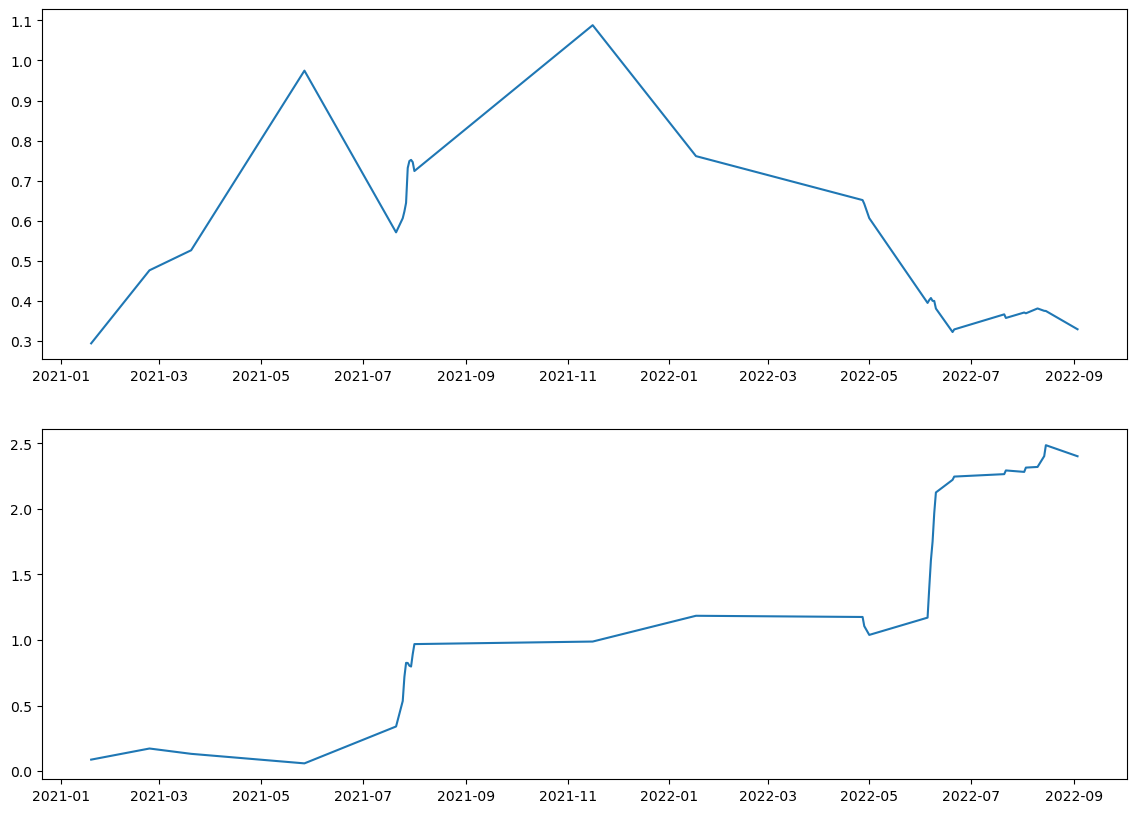

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(result[3]['close'], label='close')
ax2.plot(result[3]['tot_profit'], label='tot_profit')
plt.show()

In [532]:
account = [] # 계좌 정보
diary = [] # 매매일지


window = 14
away = 7

start_date = ''
end_date = ''

tot_data = {}

for sym in jongmok:
    data = pd.read_sql(sym, engine, index_col='datetime') # 데이터 가져오기
    tot_data[sym] = data

In [533]:
for key in tot_data:
    print(key)

# for key in jongmok[:1]:
#     print(key)
#
tot_data['btc']

btc
eth
bch
xrp
eos
ltc
trx
etc
link
xlm
ada
xmr
dash
zec
xtz
bnb
atom
ont
iota
bat
vet
neo
qtum
iost
theta
algo
zil
knc
zrx
comp
omg
doge
sxp
kava
band
rlc
waves
mkr
snx
dot
defi
yfi
bal
crv
trb
rune
sushi
srm
egld
sol
icx
storj
blz
uni
avax
ftm
hnt
enj
flm
tomo
ren
ksm
near
aave
fil
rsr
lrc
matic
ocean
cvc
bel
ctk
axs
alpha
zen
skl
grt
1inch
chz
sand
ankr
bts
lit
unfi
reef
rvn
sfp
xem
coti
chr
mana
alice
hbar
one
lina
stmx
dent
celr
hot
mtl
ogn
nkn
sc
dgb
1000shib
bake
gtc
btcdom
tlm
iotx
audio
ray
c98
mask
ata
dydx
1000xec
gala
celo
ar
klay
arpa
ctsi
lpt
ens
people
ant
rose
dusk
flow
imx
api3
gmt
ape
woo
ftt
jasmy
dar
gal
op
inj
stg
football
spell
1000lunc
luna2
ldo
cvx
icp
apt
qnt
bluebird
fet
fxs
hook
magic
t
rndr
high
mina
astr
agix
phb
gmx
cfx
stx
cocos
bnx
ach
ssv


,open,high,low,close,volume
datetime,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634
...,...,...,...,...,...
2023-02-22,24443.30,24468.50,23572.00,24171.30,730414.101
2023-02-23,24171.30,24588.00,23590.00,23928.80,751339.414
2023-02-24,23928.70,24138.60,22800.00,23175.60,731577.942


In [52]:
from datetime import datetime, timedelta

In [630]:
# start_date = "2020-09-08"
# end_date = "2023-10-01"
# amount = 100
#
# date = datetime.strptime("2020-09-08", '%Y-%m-%d')


In [622]:
column = ['Open_Date', 'Symbol', 'Ind', 'Position', 'Amount', 'Open_Price', 'Day', 'Close_Price', 'Profit', 'Profit_Amount', 'Close_Date']
Report = pd.DataFrame([], columns = column)
print(Report)

Empty DataFrame
Columns: [Open_Date, Symbol, Ind, Position, Amount, Open_Price, Day, Close_Price, Profit, Profit_Amount, Close_Date]
Index: []


In [661]:
start_date_str = "2020-09-08" #거래시작일
end_date_str = "2022-10-01" # 거래종료일

date = datetime.strptime(start_date_str, '%Y-%m-%d')
new_date = date - timedelta(days=window) #지표 생성 위한 앞 데이터
# print(new_date)
# new_date_str = new_date.strftime('%Y-%m-%d')

start_date = datetime.strptime(start_date_str, '%Y-%m-%d') # 날짜형식
end_date =  datetime.strptime(end_date_str, '%Y-%m-%d') #날짜 형식

selected_data = {} #종목에서 기간 내용 추출
for key in jongmok:
    selected_data[key] = tot_data[key].loc[new_date:end_date]

# mask = (tot_data['BTC/USDT'][])
selected_data[jongmok[2]]

,open,high,low,close,volume
datetime,,,,,
2020-08-25,291.00,292.00,267.98,275.78,331245.721
2020-08-26,275.71,279.47,271.24,275.20,232601.990
2020-08-27,275.20,277.45,258.48,264.99,330924.549
2020-08-28,265.02,272.24,261.20,268.88,210668.740
2020-08-29,268.86,273.02,266.05,268.36,180281.376
...,...,...,...,...,...
2022-09-27,116.23,120.44,112.22,114.19,1162369.252
2022-09-28,114.19,115.83,109.89,114.01,950777.066
2022-09-29,114.02,117.84,113.36,116.89,987825.788


In [637]:
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date =  datetime.strptime(end_date_str, '%Y-%m-%d')

term_str = end_date - start_date
term = term_str.days
# term_date_str = term_date.strftime('%Y-%m-%d')
term

1118

input 날짜, 종목

In [633]:
# 모델 로드
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(10, activation='relu', input_shape=(window, 4), dropout=0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.load_weights('14_7price_1d.h5')

In [674]:
column = ['Open_Date', 'Symbol', 'Ind', 'Position', 'Amount', 'Open_Price', 'Day', 'Close_Price', 'Profit', 'tot_Profit', 'Close_Date', 'tot_Amount']
Report = pd.DataFrame([], columns = column)

In [662]:
selected_data[jongmok[2]][0:0+window]

,open,high,low,close,volume
datetime,,,,,
2020-08-25,291.00,292.00,267.98,275.78,331245.721
2020-08-26,275.71,279.47,271.24,275.20,232601.990
2020-08-27,275.20,277.45,258.48,264.99,330924.549
2020-08-28,265.02,272.24,261.20,268.88,210668.740
2020-08-29,268.86,273.02,266.05,268.36,180281.376
2020-08-30,268.36,279.87,268.03,279.61,210474.728
2020-08-31,279.61,281.90,272.97,273.87,219762.428
2020-09-01,273.86,297.91,268.61,292.50,442181.468
2020-09-02,292.50,295.76,243.40,264.15,497223.975


In [669]:
print(new_date)

2020-08-25 00:00:00


In [717]:
len(Report)

0

In [1]:
start_date_str = "2022-01-01" #거래시작일
end_date_str = "2022-06-01" # 거래종료일
tot_Amount = 10000

date = datetime.strptime(start_date_str, '%Y-%m-%d')
new_date = date - timedelta(days=window) #지표 생성 위한 앞 데이터

start_date = datetime.strptime(start_date_str, '%Y-%m-%d') # 날짜형식
end_date =  datetime.strptime(end_date_str, '%Y-%m-%d') #날짜 형식

selected_data = {} #종목에서 기간 내용 추출
for key in jongmok:
    selected_data[key] = tot_data[key].loc[new_date:end_date]

pre = []
x_input=[] # 예측 Input 데이터 리스트
ind = {}
amount = 100

column = ['Open_Date', 'Symbol', 'Ind', 'Position', 'Amount', 'Open_Price', 'Day', 'state', 'Close_Price', 'Profit', 'tot_Profit', 'Close_Date', 'tot_Amount']
Report = pd.DataFrame([], columns = column)

for day in range(90):
    today_date = start_date + timedelta(days=day)
    signal = []
    # day ~ day + window 까지 종목 가져오기
    for key in jongmok[20:40]:
        x_data = selected_data[key].loc[today_date - timedelta(days=window-1):today_date][['open', 'high', 'low', 'close']]

        ## 전처리
        mean = x_data.mean()
        std = x_data.std()
        x = (x_data - mean) / std

        #LSTM 예측하기
        ind[key] = model.predict(np.array([x]))[0][0].tolist()

        #ind 값 따라 종목 찾기
        signal = [key for key, value in ind.items() if (value > 0.65 or value < 0.35)]



    Report.loc[Report['state'] == 'open', 'Day'] += 1
    #장부 업데이트
    if len(Report) > 0:
        for i in range(len(Report)):
            key = Report['Symbol'][i] # symbol
            if Report['state'][i] == "open":
                Report['Close_Price'][i] = selected_data[key].loc[today_date, 'close'] # 가격 업데이트

                open_p = Report['Open_Price'][i]
                close_p = Report['Close_Price'][i]
                profit = (close_p - open_p) / open_p

                if Report['Position'][i] == 'Long':
                    Report['Profit'][i] = profit
                elif Report['Position'][i] == 'Short':
                    Report['Profit'][i] = -profit
                tot_Amount += Report['Amount'][i] * (1 + Report['Profit'][i])
                Report['tot_Amount'][i] = tot_Amount

            if (today_date - Report['Open_Date'][i]).days == 7:
                Report['Close_Date'][i] = today_date
                Report['state'][i] = "close"

            Report['tot_Profit'] = Report['Profit'].cumsum()

    k = len(Report)
    ## 레포트 작성
    for i in range(len(signal)):
        # 0.5 보다 크면 롱 0.5 보다 작으면 포지션 숏
        if ind[signal[i]] > 0.65:
            Position = "Long"
        elif ind[signal[i]] < 0.35:
            Position = "Short"
        Symbol = signal[i]
        Report.at[k, 'Open_Date'] = today_date # 진입 날짜
        Report.at[k, 'Symbol'] = Symbol # symbol 입력
        Report.at[k, 'Ind'] = ind[Symbol]
        Report.at[k, 'Position'] = Position # 포지션 입력
        Report.at[k, 'Amount'] = amount
        Report.at[k, 'Open_Price'] = selected_data[Symbol].loc[today_date, 'close']
        Report.at[k, 'Day'] = 0
        Report.at[k, 'Close_Price'] = selected_data[Symbol].loc[today_date, 'close']
        Report.at[k, 'Profit'] = 0
        Report.at[k, 'state'] = "open"
        Report.at[k, 'tot_Amount'] = tot_Amount

        Report['tot_Profit'] = Report['Profit'].cumsum()
        k += 1



NameError: name 'datetime' is not defined

In [763]:
Report

,Open_Date,Symbol,Ind,Position,Amount,Open_Price,Day,state,Close_Price,Profit,tot_Profit,Close_Date,tot_Amount
0,2020-12-20 00:00:00,iota,0.674602,Long,100,0.3248,7,close,0.2982,-0.081897,-0.081897,2020-12-27 00:00:00,NaN
1,2020-12-21 00:00:00,bnb,0.651785,Long,100,32.13,7,close,36.026,0.121257,0.039361,2020-12-28 00:00:00,NaN
2,2020-12-21 00:00:00,iota,0.666735,Long,100,0.3046,7,close,0.3065,0.006238,0.045599,2020-12-28 00:00:00,NaN
3,2020-12-28 00:00:00,ada,0.657894,Long,100,0.17663,7,close,0.22524,0.275208,0.320807,2021-01-04 00:00:00,NaN
4,2020-12-29 00:00:00,ada,0.676552,Long,100,0.191,7,close,0.2585,0.353403,0.67421,2021-01-05 00:00:00,NaN
5,2020-12-30 00:00:00,eth,0.679249,Long,100,753.04,7,close,1212.64,0.610326,1.284536,2021-01-06 00:00:00,NaN
6,2020-12-31 00:00:00,eth,0.668398,Long,100,737.19,7,close,1227.12,0.664591,1.949127,2021-01-07 00:00:00,NaN
7,2021-01-01 00:00:00,eth,0.652923,Long,100,729.77,7,close,1218.39,0.669553,2.618681,2021-01-08 00:00:00,NaN
8,2021-01-04 00:00:00,btc,0.652399,Long,100,32031.07,7,close,35408.46,0.105441,2.724122,2021-01-11 00:00:00,NaN
9,2021-01-10 00:00:00,bat,0.650292,Long,100,0.2581,7,close,0.2745,0.063541,2.787663,2021-01-17 00:00:00,NaN


In [772]:
plus_cnt = (Report['Profit'] > 0).sum()
minus_cnt = (Report['Profit'] < 0).sum()
Prob = plus_cnt / len(Report)
print(len(Report), plus_cnt, minus_cnt, Prob, Report['Profit'].mean(), Report['Profit'].sum())

71 61 10 0.8591549295774648 0.2259777828231746 16.044422580445396


In [773]:
Report

,Open_Date,Symbol,Ind,Position,Amount,Open_Price,Day,state,Close_Price,Profit,tot_Profit,Close_Date,tot_Amount
0,2022-01-02 00:00:00,waves,0.345405,Short,100,15.38,7,close,14.113,0.08238,0.08238,2022-01-09 00:00:00,11641.874473
1,2022-01-04 00:00:00,rlc,0.341406,Short,100,3.4296,7,close,2.8014,0.18317,0.26555,2022-01-11 00:00:00,12553.737395
2,2022-01-04 00:00:00,dot,0.325106,Short,100,28.677,7,close,25.536,0.10953,0.37508,2022-01-11 00:00:00,12664.690424
3,2022-01-08 00:00:00,knc,0.348818,Short,100,1.525,7,close,1.526,-0.000656,0.374424,2022-01-15 00:00:00,15981.499951
4,2022-01-09 00:00:00,knc,0.304745,Short,100,1.423,7,close,1.538,-0.080815,0.293609,2022-01-16 00:00:00,17584.717854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2022-03-25 00:00:00,zil,0.662692,Long,100,0.04786,6,open,0.17973,2.755328,15.342953,NaN,64573.837928
67,2022-03-25 00:00:00,zrx,0.660979,Long,100,0.5844,6,open,0.7736,0.323751,15.666704,NaN,64706.213014
68,2022-03-25 00:00:00,kava,0.657793,Long,100,3.7478,6,open,4.5091,0.203133,15.869836,NaN,64826.526264
69,2022-03-25 00:00:00,rlc,0.657234,Long,100,2.0831,6,open,2.2432,0.076857,15.946693,NaN,64934.211925


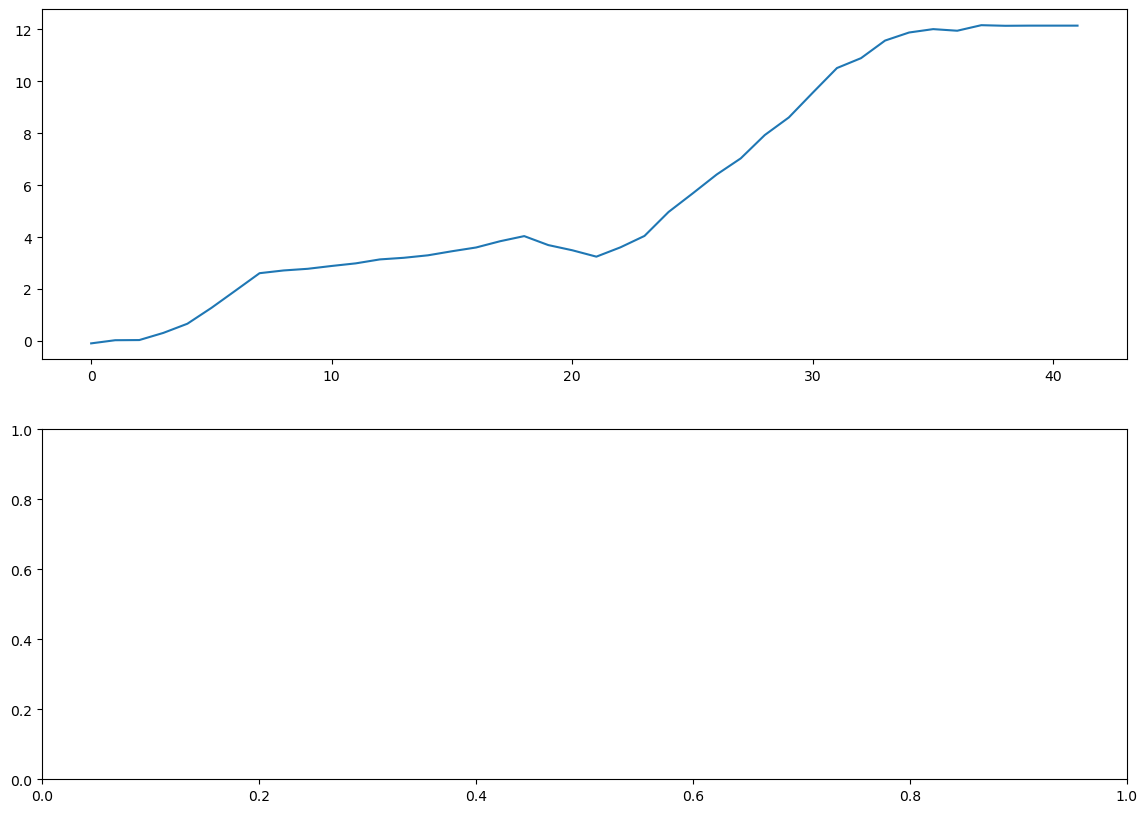

In [766]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(Report['tot_Profit'], label='close')
# ax2.plot(result[3]['tot_profit'], label='tot_profit')
plt.show()